# Physics-Informed Neural Networks (PINNs) for structural health monitoring: A case study for Kirchhoff-Love Plates



In [ ]:
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy import interpolate
sns.set_theme(style="whitegrid")

from typing import Tuple, Callable, List, Union
from tensorflow.experimental.numpy import isclose
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Set the random seed for reproducibility
np.random.seed(4)
tf.random.set_seed(4)

## Utility functions
We start by defining a few utility functions that will be useful later. The first, compute_derivatives, computes all the derivatives necessary to formulate NNs objective (it is a second order differential equation), while compute_moments is used for computing the boundary conditions.



In [ ]:
def compute_derivatives(x, y, u):
    """
    Computes the derivatives of `u` with respect to `x` and `y`.

    Parameters
    ----------
    x : tf.Tensor
        The x-coordinate of the collocation points, of shape (batch_size, 1).
    y : tf.Tensor
        The y-coordinate of the collocation points, of shape (batch_size, 1).
    u : tf.Tensor
        The prediction made by the PINN, of shape (batch_size, 1).

    Returns
    -------
    tuple
        The derivatives of `u` with respect to `x`, `y`, `xx`, `yy`, `xy`.
    """
    dudx, dudy = tf.gradients(u, [x, y])
    dudxx = tf.gradients(dudx, x)[0]
    dudyy = tf.gradients(dudy, y)[0]
    dudxxx, dudxxy = tf.gradients(dudxx, [x, y])
    dudyyy = tf.gradients(dudyy, y)[0]
    dudxxxx = tf.gradients(dudxxx, x)[0]
    dudxxyy = tf.gradients(dudxxy, y)[0]
    dudyyyy = tf.gradients(dudyyy, y)[0]
    return dudxx, dudyy, dudxxxx, dudyyyy, dudxxyy


def compute_moments(D, nue, dudxx, dudyy):
    """
    Computes the moments along the x and y axes.

    Parameters
    ----------
    D : float
        The flexural stiffness.
    nue : float
        Poisson's ratio.
    dudxx : tf.Tensor
        The second-order derivative of `u` with respect to `x`, of shape (batch_size, 1).
    dudyy : tf.Tensor
        The second-order derivative of `u` with respect to `y`, of shape (batch_size, 1).

    Returns
    -------
    tuple
        The moments along the x and y axes.
    """
    mx = -D * (dudxx + nue * dudyy)
    my = -D * (nue * dudxx + dudyy)
    return mx, my


# Problem Setup
This class represents a plate under the Kirchhoff-Love plate bending theory. It provides a set of utility functions to train a Neural Network  on the Kirchhoff-Love theory. The class has functions that generate training  data, impoprt the analytical solution data, and  calculate loss.

In [ ]:
class Kirchhoffplate:
    """
    Class representing a Kirchhoff plate, providing several methods for training a Physics-Informed Neural Network.
    """
    def __init__(self, p: Callable[[tf.Tensor, tf.Tensor], tf.Tensor], T: float, nue: float, E: float, H: float, W: float):
        """
        Initialize the Kirchhoffplate class.

        PARAMETERS
        ----------------
        p : Callable[[tf.Tensor, tf.Tensor], tf.Tensor]
            The load function, taking x and y coordinates as inputs and returning the load.
        T : float
            Thickness of the plate.
        nue : float
            Poisson's ratio.
        E : float
            Young's modulus.
        W : float
            Width of the plate.
        H : float
            Height of the plate.
        """
        self.p = p
        self.T = T
        self.nue = nue
        self.E = E
        self.D = (E * T**3) / (12 * (1 - nue**2)) # flexural stiffnes of the plate
        self.H = H
        self.W = W
        self.num_terms = 3

    def training_batch(self, batch_size_domain:int=800, batch_size_boundary:int=100) -> Tuple[tf.Tensor, tf.Tensor]:
        """
        Generates a batch of collocation points by randomly sampling `batch_size_domain` points inside the domain
        and `batch_size_boundary` points on each of the four boundaries.

        PARAMETERS
        --------------------
        batch_size_domain : int
            number of points to be sampled inside of the domain
        batch_size_boundary : int
            number of points to be sampled on each of the four boundaries
        """
        x_in = tf.random.uniform(shape=(batch_size_domain, 1), minval=0, maxval=self.W)
        x_b1 = tf.zeros(shape=(batch_size_boundary, 1))
        x_b2 = tf.zeros(shape=(batch_size_boundary, 1)) + self.W
        x_b3 = tf.random.uniform(shape=(batch_size_boundary, 1), minval=0, maxval=self.W)
        x_b4 = tf.random.uniform(shape=(batch_size_boundary, 1), minval=0, maxval=self.W)
        x_m = tf.constant([0, 4, 1, 3, 2, 1, 3, 0, 4], shape=(9,1), dtype= tf.float32 )
        x = tf.concat([x_in, x_b1, x_b2, x_b3, x_b4, x_m], axis=0)

        y_in = tf.random.uniform(shape=(batch_size_domain, 1), minval=0, maxval=self.H)
        y_b1 = tf.random.uniform(shape=(batch_size_boundary, 1), minval=0, maxval=self.H)
        y_b2 = tf.random.uniform(shape=(batch_size_boundary, 1), minval=0, maxval=self.H)
        y_b3 = tf.zeros(shape=(batch_size_boundary, 1))
        y_b4 = tf.zeros(shape=(batch_size_boundary, 1)) + self.H
        y_m = tf.constant([0, 0, 1, 1, 2, 3, 3, 4, 4], shape=(9,1), dtype= tf.float32 )
        y = tf.concat([y_in, y_b1, y_b2, y_b3, y_b4, y_m], axis=0)

        return x, y

    def get_train_dataset(self, batch_size_domain:int=800, batch_size_boundary:int=100):
        """
        Creates a tf.data.Dataset generator for training.

        Parameters
        ----------
        batch_size_domain : int
            number of points to be sampled inside of the domain. Default is 800.
        batch_size_boundary : int
            number of points to be sampled on each of the four boundaries. Default is 100.

        Returns
        -------
        tf.data.Dataset
            A `tf.data.Dataset` generator for training.
        """
        def generator():
            while True:
                xy = tf.concat(self.training_batch(batch_size_domain, batch_size_boundary), axis=-1)
                yield xy, xy

        return tf.data.Dataset.from_generator(
            generator,
            output_types=(tf.float32, tf.float32),
            output_shapes=((None, 2), (None, 2))
        )
    def compute_loss(self, x, y, preds):
        """
        Computes the physics-informed loss for Kirchhoff's plate bending equation.
        """
        u = preds[:, 0:1]
        dudxx = preds[:, 1:2]
        dudyy = preds[:, 2:3]
        dudxxxx = preds[:, 3:4]
        dudyyyy = preds[:,4:5]
        dudxxyy = preds [:, 5:6]

        # governing equation loss
        f = dudxxxx + 2 * dudxxyy + dudyyyy - self.p(x, y) / self.D
        L_f = f**2

        # determine which points are on the boundaries of the domain
        # if a point is on either of the boundaries, its value is 1 and 0 otherwise
        x_lower = tf.cast(isclose(x, 0.     , rtol=0., atol=1e-7), dtype=tf.float32)
        x_upper = tf.cast(isclose(x, self.W, rtol=0., atol=1e-7), dtype=tf.float32)
        y_lower = tf.cast(isclose(y, 0.     , rtol=0., atol=1e-7), dtype=tf.float32)
        y_upper = tf.cast(isclose(y, self.H, rtol=0., atol=1e-7), dtype=tf.float32)

        # compute 0th order boundary condition loss
        L_w = ((x_lower + x_upper + y_lower + y_upper) * u)**2
        # compute 2nd order boundary condition loss
        mx, my = compute_moments(self.D, self.nue, dudxx, dudyy)
        L_m = ((x_lower + x_upper + y_lower + y_upper) * mx)**2 + ((x_lower + x_upper + y_lower + y_upper) * my)**2

        u_d=tf.constant([0.00000000, 0.00000000, 0.00024037, 0.00024035, 0.00045886, 0.00024036, 0.00024037, 0.00000000, 0.00000000], shape=(9,1), dtype=tf.float32 )
        # Calculate the indices for the last rows
        batch_size = tf.shape(preds)[0]
        indices = tf.range(batch_size - 9, batch_size, dtype=tf.int32)

        # Extract the corresponding predictions
        selected_preds = tf.gather(preds[:, 0:1], indices)

        # Compute the new loss term L_u
        L_u_partial = (u_d - selected_preds)**2

        # Create a tensor of zeros with the same shape as the existing loss terms
        L_u_full = tf.zeros_like(preds[:, :1])

        # Replace the last five elements with the values from L_u_partial
        L_D = tf.tensor_scatter_nd_update(L_u_full, tf.expand_dims(indices, axis=1), L_u_partial)

        return L_f, L_w, L_m , L_D


## Kirchhoff Loss Function Weights Balancing

In [ ]:
class KirchhoffLoss(tf.keras.losses.Loss):
    """
    Kirchhoff Loss for plate bending physics-informed neural network.

    Parameters
    ----------
    plate: Kirchhoffplate
        The Kirchhoffplate object representing the plate bending physics.
    name: str, optional
        The name of the custom loss.
    """
    def __init__(self, plate: Kirchhoffplate, name: str = "kirchhoff_loss"):
        super().__init__(name=name)
        self.plate = plate
        self.weight_L_f = tf.Variable(1.0, trainable=True, constraint=lambda x: tf.clip_by_value(x, 0, 1))
        self.weight_L_w = tf.Variable(1.0, trainable=True, constraint=lambda x: tf.clip_by_value(x, 0, 1))
        self.weight_L_m = tf.Variable(1.0, trainable=True, constraint=lambda x: tf.clip_by_value(x, 0, 1))
        self.weight_L_D = tf.Variable(1.0, trainable=True, constraint=lambda x: tf.clip_by_value(x, 0, 1))

    def call(self, xy, preds):
        x, y = xy[:, :1], xy[:, 1:]
        L_f, L_w, L_m, L_D = self.plate.compute_loss(x, y, preds)
        #L_f, L_b0, L_b2 = self.plate.compute_loss(x, y, preds)

        # Add constraint to ensure the sum of the weights is 1
        weights_sum = self.weight_L_f + self.weight_L_w + self.weight_L_m + self.weight_L_D
        self.weight_L_f.assign(self.weight_L_f / weights_sum)
        self.weight_L_w.assign(self.weight_L_w / weights_sum)
        self.weight_L_m.assign(self.weight_L_m / weights_sum)
        self.weight_L_D.assign(self.weight_L_D / weights_sum)

        loss = self.weight_L_f * tf.reduce_mean(L_f) + \
                     self.weight_L_w * tf.reduce_mean(L_w) + \
                     self.weight_L_m * tf.reduce_mean(L_m)  + \
                     self.weight_L_D* tf.reduce_mean(L_D)
        return loss

## NN Model

In [ ]:
class KirchhoffMetric(tf.keras.metrics.Metric):
    """
    Kirchhoff metric to log the values of each loss term, i.e. L_f, L_w and L_m.
    """
    def __init__(self, plate: Kirchhoffplate, name='kirchhoff_metric', **kwargs):
        """Initialize Kirchhoff metric with a Kirchhoffplate instance and metric name.

        Parameters
        ----------
        plate : Kirchhoffplate
            Instance of the Kirchhoffplate.
        name : str, optional
            Name of the metric. Defaults to 'kirchhoff_metric'.
        """
        super().__init__(name=name, **kwargs)
        self.plate = plate
        self.L_f_mean = self.add_weight(name='L_f_mean', initializer='zeros')
        self.L_w_mean = self.add_weight(name='L_w_mean', initializer='zeros')
        self.L_m_mean = self.add_weight(name='L_m_mean', initializer='zeros')
        self.L_D_mean = self.add_weight(name='L_D_mean', initializer='zeros')

    def update_state(self, xy, y_pred, sample_weight=None):
        x, y = xy[:, :1], xy[:, 1:]
        L_f, L_w, L_m, L_D= self.plate.compute_loss(x, y, y_pred)
        self.L_f_mean.assign(tf.reduce_mean(L_f[:, 0], axis=0))
        self.L_w_mean.assign(tf.reduce_mean(L_w[:, 0], axis=0))
        self.L_m_mean.assign(tf.reduce_mean(L_m[:, 0], axis=0))
        self.L_D_mean.assign(tf.reduce_mean(L_D[:, 0], axis=0))
    def reset_state(self):
        self.L_f_mean.assign(0)
        self.L_w_mean.assign(0)
        self.L_m_mean.assign(0)
        self.L_D_mean.assign(0)
    def result(self):
        return {'L_f': self.L_f_mean, 'L_w': self.L_w_mean, 'L_m': self.L_m_mean, 'L_D': self.L_D_mean}

In [ ]:
class KirchhoffPINN(tf.keras.Model):
    """
   This class is a implementation of a  neural network
    for the Kirchhoff plate bending.
    """
    def __init__(self, layer_widths: List[int]=[64, 64, 64, 64], activation: Union[str, Callable]='tanh', **kwargs):
        """
        Parameters
        ----------
        layer_widths : List[int], optional
            List of integers representing the widths of the hidden layers in the model.
        activation : Union[str, Callable], optional
            Activation function to be applied in each layer.
        """
        super().__init__(**kwargs)
        self.layer_sequence = [tf.keras.layers.Dense(width, activation=activation, kernel_initializer='glorot_normal') for width in layer_widths]
        self.layer_sequence.append(tf.keras.layers.Dense(1, kernel_initializer='glorot_normal'))

    def call(self, xy, training=None, mask=None):
        x, y = xy[:, :1], xy[:, 1:]

        u = Concatenate()([x, y])
        for layer in self.layer_sequence:
            u = layer(u)

        dudxx, dudyy, dudxxxx, dudyyyy, dudxxyy = compute_derivatives(x, y, u)

        return tf.concat([u, dudxx, dudyy, dudxxxx, dudyyyy, dudxxyy], axis=-1)

***Concrete Slab Parameters***

In [ ]:
W = 4
H = 4
T = 0.2
E = 31724
nue = 0.2
p0 = 0.00948
D = (E * T**3) / (12 * (1 - nue**2)) # flexural stiffnes of the plate

load = lambda x, y: p0 + (x-x)*(y-y)
#u_val = lambda x, y: p0 / (np.pi**4 * D * (W**-2 + H**-2)**2) * tf.math.sin(x * np.pi / W) * tf.math.sin(y * np.pi / H)
plate = Kirchhoffplate(p = load, T=T, nue=nue, E=E, W=W, H=H)
#plate.visualise()
x, y = plate.training_batch(batch_size_domain= 800, batch_size_boundary =100)

# Create a scatter plot of the load p over the plate
plt.scatter(x, y, cmap='viridis')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Load Distribution over the Plate')
plt.colorbar(label='Load (MN/m^2)')
plt.show()
print(x)
print(y)

*PINNs* model Hypereparameters

In [ ]:
pinn = KirchhoffPINN()
loss = KirchhoffLoss(plate)
pinn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=loss, metrics=[KirchhoffMetric(plate), 'accuracy'])

In [ ]:
h = pinn.fit(
    plate.get_train_dataset(),
    epochs=2000,
    steps_per_epoch=50,
    callbacks=[
        ReduceLROnPlateau(monitor='loss', factor=0.1, patience=30, min_delta=0, verbose=True),
        EarlyStopping(monitor='loss', patience=100, restore_best_weights=True, verbose=True)
    ]
)

Epoch 1/2000
50/50 [==============================] - 145s 157ms/step - loss: 3.1690e-04 - L_f: 1.6774e-07 - L_w: 2.7329e-05 - L_m: 0.0012 - L_D: 6.0604e-07 - accuracy: 0.3003 - lr: 0.0010
Epoch 2/2000
50/50 [==============================] - 8s 156ms/step - loss: 1.2594e-06 - L_f: 1.6788e-07 - L_w: 4.3788e-07 - L_m: 4.3415e-06 - L_D: 9.5722e-09 - accuracy: 0.2823 - lr: 0.0010
Epoch 3/2000
50/50 [==============================] - 8s 157ms/step - loss: 1.9586e-07 - L_f: 1.8795e-07 - L_w: 3.2266e-08 - L_m: 5.5967e-07 - L_D: 1.3025e-09 - accuracy: 0.1603 - lr: 0.0010
Epoch 4/2000
50/50 [==============================] - 8s 156ms/step - loss: 1.4867e-07 - L_f: 1.9984e-07 - L_w: 1.3913e-08 - L_m: 3.7914e-07 - L_D: 8.3337e-10 - accuracy: 0.1421 - lr: 0.0010
Epoch 5/2000
50/50 [==============================] - 8s 155ms/step - loss: 1.2332e-07 - L_f: 2.0560e-07 - L_w: 6.0655e-09 - L_m: 2.8018e-07 - L_D: 6.3548e-10 - accuracy: 0.1055 - lr: 0.0010
Epoch 6/2000
50/50 [===========================

Visualise the progress of the several loss terms as well as the error against the analytical solution.

In [ ]:
x = np.array([0, 4, 1, 3, 2, 2, 2, 1, 3, 1, 3, 0, 4], dtype=np.float32).reshape((13, 1))
y = np.array([0, 0, 1, 1, 1, 3, 2, 2, 2, 3, 3, 4, 4], dtype=np.float32).reshape((13, 1))

# Create a meshgrid of x, y data
X, Y = np.meshgrid(x, y)
input_data = np.column_stack((X.flatten(), Y.flatten()))

# Predict the model for the new x, y data
predictions = pinn.predict(input_data)

x_values = [0, 4, 1, 3, 2, 2, 2, 1, 3, 1, 3, 0, 4]
y_values = [0, 0, 1, 1, 1, 3, 2, 2, 2, 3, 3, 4, 4]

pred_values = []
for x, y in zip(x_values, y_values):
    index = np.where((input_data[:, 0] == x) & (input_data[:, 1] == y))[0][0]
    value = predictions[index, 2]
    #value = predictions
    pred_values.append(value)

print(pred_values)

6/6 [==============================] - 0s 42ms/step
[7.672905e-06, 1.1524884e-05, -0.00015145913, -0.00015068814, -0.0002096923, -0.00020070192, -0.00025577814, -0.0001794617, -0.00017782942, -0.00014491369, -0.00014570478, 1.0532342e-05, 1.2926845e-05]


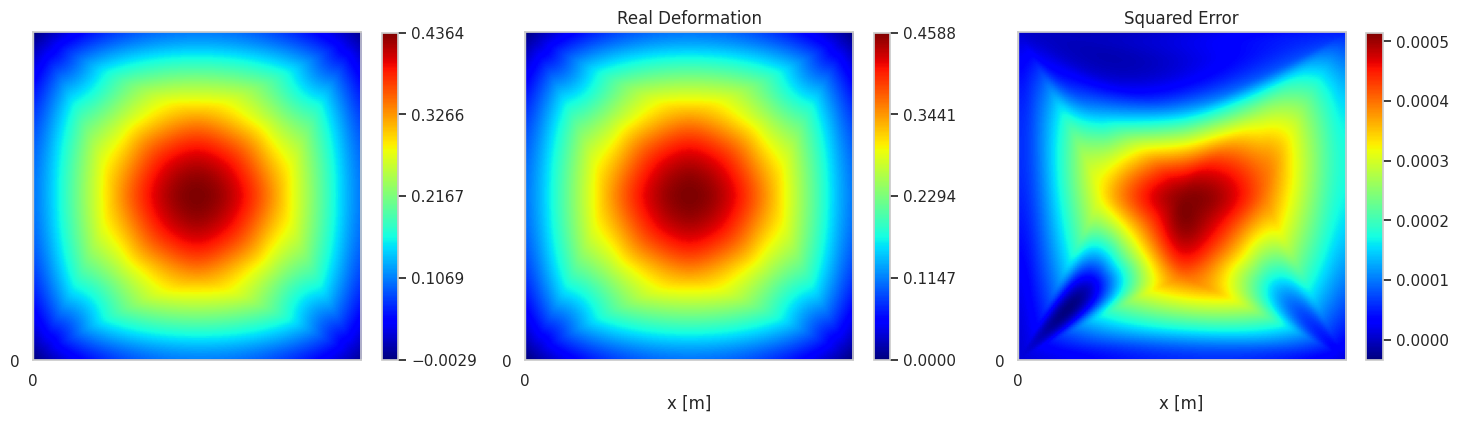

Maximum squared error: 0.00050569663
Root Mean Squared Error (RMSE): 0.013854901
CV(RMSE) for Deformation (u): 6.558915 %
Normalized Mean Bias Error (NMBE): 4.960113391280174 %


In [ ]:
# Define u_real as a 2D array of shape (150, 150)
u_real=tf.constant([0.00000000, 0.00000000, 0.00024037, 0.00024035,0.00033146, 0.00033144, 0.00045886,
                         0.00033147,  0.00033144, 0.00024036, 0.00024034, 0.00000000, 0.00000000], shape=(13,1), dtype=tf.float32 )*1000

u_pred =tf.constant([-1.637789e-06, 7.0339884e-06, 0.0002289351, 0.00022384076, 0.00031958724, 0.00031156762,
                     0.0004363723, 0.00031355134, 0.00031150243, 0.00023244991, 0.00022627524, -2.9102084e-06, 3.312889e-06], shape=(13,1), dtype=tf.float32)*1000
# Compute the element-wise squared difference between u_pred and u_real
sq_error = tf.square(u_pred - u_real)
# Define x and y axis
x = tf.constant([0, 4, 1, 3, 2, 2, 2, 1, 3, 1, 3, 0, 4], shape=(13, 1), dtype=tf.float32)
y = tf.constant([0, 0, 1, 1, 1, 3, 2, 2, 2, 3, 3, 4, 4], shape=(13, 1), dtype=tf.float32)
# Convert x and y tensors to numpy arrays
x = x.numpy()
y = y.numpy()
u_pred = u_pred.numpy().flatten()
u_real = u_real.numpy().flatten()
sq_error = sq_error.numpy().flatten()
# Create a meshgrid of x and y coordinates for contour plot
X, Y = np.meshgrid(np.linspace(x.min(), x.max(), 150), np.linspace(y.min(), y.max(), 150))

# Interpolate u_pred and u_real values to the meshgrid points
u_pred_interp = interpolate.griddata((x.flatten(), y.flatten()), u_pred, (X, Y), method='cubic')
u_real_interp = interpolate.griddata((x.flatten(), y.flatten()), u_real, (X, Y), method='cubic')
sq_error_interp =interpolate.griddata((x.flatten(), y.flatten()), sq_error, (X, Y), method='cubic')

# Plot u_pred, u_real, and the contour plot of squared error
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
im0 = axs[0].imshow(u_pred_interp, cmap='jet', origin='lower', aspect='equal', extent=[x.min(), x.max(), y.min(), y.max()])
cb0 = fig.colorbar(im0, ax=axs[0], shrink=0.85, ticks=np.linspace(u_pred_interp.min(), u_pred_interp.max(), 5))
#axs[0].set_title('Predicted Deformation')
#axs[0].set_xlabel('x [m]')
#axs[0].set_ylabel('y [m]')
axs[0].set_xticks(np.arange(x.min(), x.max(), x.max()))
axs[0].set_yticks(np.arange(y.min(), y.max(), y.max()))

im1 = axs[1].imshow(u_real_interp, cmap='jet', origin='lower', aspect='equal', extent=[x.min(), x.max(), y.min(), y.max()])
cb1 = fig.colorbar(im1, ax=axs[1], shrink=0.85, ticks=np.linspace(u_real_interp.min(), u_real_interp.max(), 5))
axs[1].set_title('Real Deformation')
axs[1].set_xlabel('x [m]')
#axs[1].set_ylabel('y [m]')
axs[1].set_xticks(np.arange(x.min(), x.max(), x.max()))
#axs[1].set_xticks(np.arange(x.min(), x.max()))
axs[1].set_yticks(np.arange(y.min(), y.max(), y.max()))

#im2 = axs[2].contourf(X, Y, sq_error_interp, cmap='jet', levels=20, aspect='equal', extent=[x.min(), x.max(), y.min(), y.max()])
im2 = axs[2].imshow(sq_error_interp, cmap='jet', aspect='equal', extent=[x.min(), x.max(), y.min(), y.max()])
cb2 = fig.colorbar(im2, ax=axs[2], shrink=0.85)
axs[2].set_title('Squared Error')
axs[2].set_xlabel('x [m]')
#axs[2].set_ylabel('y [m]')
axs[2].set_xticks(np.arange(x.min(), x.max(), x.max()))
axs[2].set_yticks(np.arange(y.min(), y.max(), y.max()))

plt.show()
max_sq_error = np.max(sq_error)
print("Maximum squared error:", max_sq_error)
rmse = np.sqrt(np.mean(sq_error))
print("Root Mean Squared Error (RMSE):", rmse)
u_cv_rmse = (rmse / tf.reduce_mean(u_real)) * 100
print("CV(RMSE) for Deformation (u):", u_cv_rmse.numpy(), '%')

nmbe = np.sum(u_real - u_pred) / np.sum(u_real) * 100
print("Normalized Mean Bias Error (NMBE):", nmbe, '%')

In [ ]:
dudxx= [1.3943267e-05, 1.3154873e-05, -0.0001510132, -0.00014792744, -0.00017784309, -0.00017611869, -0.00025421503, -0.0002074721, -0.00020170055, -0.00014770747, -0.00014573021, 1.1290769e-05, 1.0621792e-05]

dudyy= [7.672905e-06, 1.1524884e-05, -0.00015145913, -0.00015068814, -0.0002096923, -0.00020070192, -0.00025577814, -0.0001794617, -0.00017782942, -0.00014491369, -0.00014570478, 1.0532342e-05, 1.2926845e-05]

mx = [-D * (x + nue * y) for x, y in zip(dudxx, dudyy)]
my = [-D * (nue * x + y) for x, y in zip(dudxx, dudyy)]

mx_rounded = [round(value, 6) for value in mx]
my_rounded = [round(value, 6) for value in my]

print("mx =", mx_rounded)
print("my =", my_rounded)


mx = [-0.000341, -0.000341, 0.003994, 0.003923, 0.004842, 0.004764, 0.006727, 0.005361, 0.005227, 0.003893, 0.003853, -0.000295, -0.000291]
my = [-0.00023, -0.000312, 0.004002, 0.003972, 0.005403, 0.005198, 0.006755, 0.004868, 0.004806, 0.003843, 0.003852, -0.000282, -0.000332]


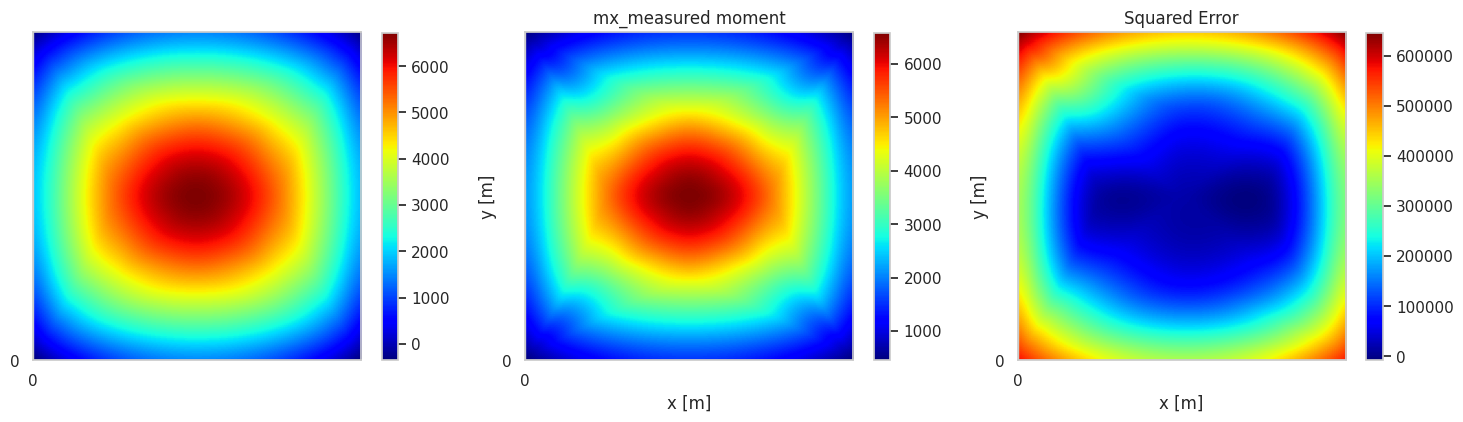

Maximum squared error: 646416.0
Root Mean Squared Error (RMSE): 500.67502
CV(RMSE) for mx: 15.477662 %
Normalized Mean Bias Error (NMBE): 1.751849241554737 %


In [ ]:
mx_real = tf.constant([0.000463, 0.000463, 0.003524, 0.0035254, 0.004518,
                       0.004518, 0.0065893, 0.005239, 0.005239, 0.003524, 0.003524, 0.000463, 0.000463], shape=(13, 1), dtype=tf.float32)*1000000
#Reshape  my into a 2D array of shape (3, 3)
mx_pred =tf.constant([-0.000341, -0.000341, 0.003994, 0.003923, 0.004842, 0.004764, 0.006727, 0.005361,
                      0.005227, 0.003893, 0.003853, -0.000295, -0.000291]
, shape=(13,1), dtype=tf.float32)*1000000

# Compute the element-wise squared difference between  my and my_real
mx_sq_error = tf.square(mx_pred - mx_real)
# Define x and y axis
x = tf.constant([0, 4, 1, 3, 2, 2, 2, 1, 3, 1, 3, 0, 4], shape=(13, 1), dtype=tf.float32)
y = tf.constant([0, 0, 1, 1, 1, 3, 2, 2, 2, 3, 3, 4, 4], shape=(13, 1), dtype=tf.float32)

# Convert x and y tensors to numpy arrays
x = x.numpy()
y = y.numpy()
mx_pred = mx_pred.numpy().flatten()
mx_real = mx_real.numpy().flatten()
mx_sq_error = mx_sq_error.numpy().flatten()
# Create a meshgrid of x and y coordinates for contour plot
X, Y = np.meshgrid(np.linspace(x.min(), x.max(), 150), np.linspace(y.min(), y.max(), 150))

# Interpolate my and my_real values to the meshgrid points
mx_pred_interp = interpolate.griddata((x.flatten(), y.flatten()), mx_pred, (X, Y), method='cubic')
mx_real_interp = interpolate.griddata((x.flatten(), y.flatten()), mx_real, (X, Y), method='cubic')
mx_sq_error_interp =interpolate.griddata((x.flatten(), y.flatten()), mx_sq_error, (X, Y), method='cubic')

# Plot mx, mx_real, and the contour plot of squared error
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
im0 = axs[0].imshow(mx_pred_interp, cmap='jet', origin='lower', aspect='equal', extent=[x.min(), x.max(), y.min(), y.max()])
cb0 = fig.colorbar(im0, ax=axs[0], shrink=0.85)
#axs[0].set_title('mx_predicted moment')
#axs[0].set_xlabel('x [m]')
#axs[0].set_ylabel('y [m]')
axs[0].set_xticks(np.arange(0, 0.01, 1))
axs[0].set_yticks(np.arange(0, 0.01, 1))
#axs[0].set_xticks(np.arange(x.min(), x.max(), x.max()))
#axs[0].set_yticks(np.arange(y.min(), y.max(), y.max()))

im1 = axs[1].imshow(mx_real_interp, cmap='jet', origin='lower', aspect='equal', extent=[x.min(), x.max(), y.min(), y.max()])
cb1 = fig.colorbar(im1, ax=axs[1], shrink=0.85)
axs[1].set_title('mx_measured moment')
axs[1].set_xlabel('x [m]')
axs[1].set_ylabel('y [m]')
#axs[1].set_xticks(np.arange(0.00, 0.01, 1))
#axs[1].set_yticks(np.arange(0.00, 0.01, 1))
axs[1].set_xticks(np.arange(x.min(), x.max(), x.max()))
axs[1].set_yticks(np.arange(y.min(), y.max(), y.max()))

#im2 = axs[2].contourf(X, Y, sq_error_interp, cmap='jet', levels=20, aspect='equal', extent=[x.min(), x.max(), y.min(), y.max()])
im2 = axs[2].imshow(mx_sq_error_interp, cmap='jet', aspect='equal', extent=[x.min(), x.max(), y.min(), y.max()])
cb2 = fig.colorbar(im2, ax=axs[2], shrink=0.85)
axs[2].set_title('Squared Error')
axs[2].set_xlabel('x [m]')
axs[2].set_ylabel('y [m]')
axs[2].set_xticks(np.arange(x.min(), x.max(), x.max()))
axs[2].set_yticks(np.arange(y.min(), y.max(), y.max()))
plt.show()

max_sq_error = np.max(mx_sq_error)
print("Maximum squared error:", max_sq_error)
rmse = np.sqrt(np.mean(mx_sq_error))
print("Root Mean Squared Error (RMSE):", rmse)
mx_cv_rmse = (rmse / tf.reduce_mean(mx_real)) * 100
print("CV(RMSE) for mx:", mx_cv_rmse.numpy(), '%')

nmbe = np.sum(mx_real - mx_pred) / np.sum(mx_real) * 100
print("Normalized Mean Bias Error (NMBE):", nmbe, '%')

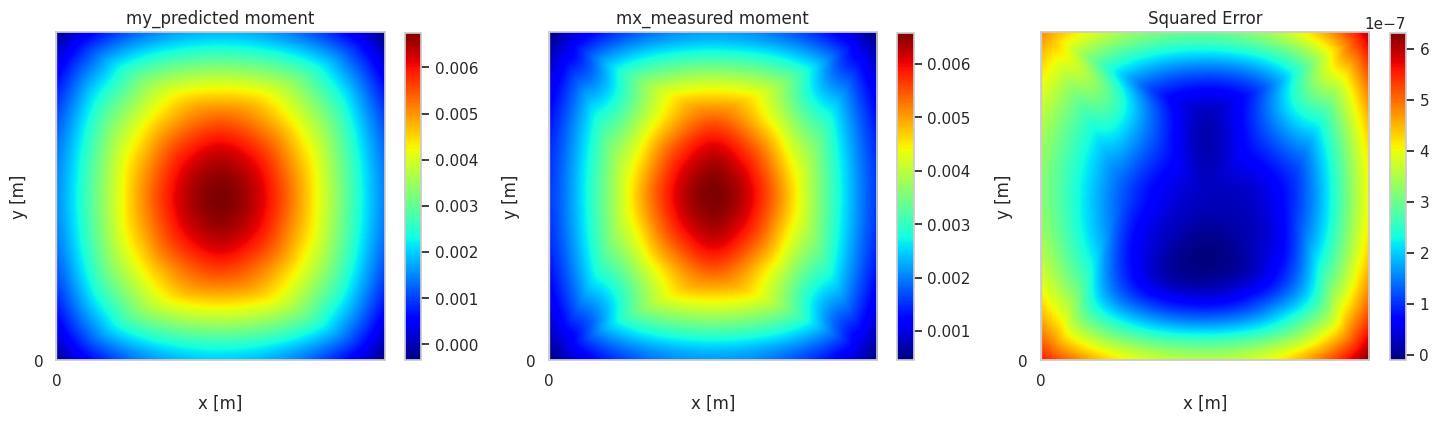

Maximum squared error: 6.32025e-07
Root Mean Squared Error (RMSE): 0.0004935493
CV(RMSE) for my: 15.25738 %
Normalized Mean Bias Error (NMBE): 1.2120519764721394 %


In [ ]:
my_real = tf.constant([0.000463, 0.000463, 0.003524, 0.0035254, 0.005239,
                       0.005239, 0.0065893, 0.004518, 0.004518, 0.003524, 0.003524, 0.000463, 0.000463], shape=(13, 1), dtype=tf.float32)
#Reshape  my into a 2D array of shape (3, 3)
my_pred =tf.constant([-0.00023, -0.000312, 0.004002, 0.003972, 0.005403, 0.005198, 0.006755,
                      0.004868, 0.004806, 0.003843, 0.003852, -0.000282, -0.000332]
, shape=(13,1), dtype=tf.float32)


# Compute the element-wise squared difference between  my and my_real
my_sq_error = tf.square(my_pred - my_real)
# Define x and y axis
x = tf.constant([0, 4, 1, 3, 2, 2, 2, 1, 3, 1, 3, 0, 4], shape=(13, 1), dtype=tf.float32)
y = tf.constant([0, 0, 1, 1, 1, 3, 2, 2, 2, 3, 3, 4, 4], shape=(13, 1), dtype=tf.float32)

# Convert x and y tensors to numpy arrays
x = x.numpy()
y = y.numpy()
my_pred = my_pred.numpy().flatten()
my_real = my_real.numpy().flatten()
my_sq_error = my_sq_error.numpy().flatten()
# Create a meshgrid of x and y coordinates for contour plot
X, Y = np.meshgrid(np.linspace(x.min(), x.max(), 150), np.linspace(y.min(), y.max(), 150))

# Interpolate my and my_real values to the meshgrid points
my_pred_interp = interpolate.griddata((x.flatten(), y.flatten()), my_pred, (X, Y), method='cubic')
my_real_interp = interpolate.griddata((x.flatten(), y.flatten()), my_real, (X, Y), method='cubic')
my_sq_error_interp =interpolate.griddata((x.flatten(), y.flatten()), my_sq_error, (X, Y), method='cubic')

# Plot mx, mx_real, and the contour plot of squared error
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
im0 = axs[0].imshow(my_pred_interp, cmap='jet', origin='lower', aspect='equal', extent=[x.min(), x.max(), y.min(), y.max()])
cb0 = fig.colorbar(im0, ax=axs[0], shrink=0.85)
axs[0].set_title('my_predicted moment')
axs[0].set_xlabel('x [m]')
axs[0].set_ylabel('y [m]')
axs[0].set_xticks(np.arange(0, 0.01, 1))
axs[0].set_yticks(np.arange(0, 0.01, 1))
#axs[0].set_xticks(np.arange(x.min(), x.max(), x.max()))
#axs[0].set_yticks(np.arange(y.min(), y.max(), y.max()))

im1 = axs[1].imshow(my_real_interp, cmap='jet', origin='lower', aspect='equal', extent=[x.min(), x.max(), y.min(), y.max()])
cb1 = fig.colorbar(im1, ax=axs[1], shrink=0.85)
axs[1].set_title('mx_measured moment')
axs[1].set_xlabel('x [m]')
axs[1].set_ylabel('y [m]')
#axs[1].set_xticks(np.arange(0.00, 0.01, 1))
#axs[1].set_yticks(np.arange(0.00, 0.01, 1))
axs[1].set_xticks(np.arange(x.min(), x.max(), x.max()))
axs[1].set_yticks(np.arange(y.min(), y.max(), y.max()))

#im2 = axs[2].contourf(X, Y, sq_error_interp, cmap='jet', levels=20, aspect='equal', extent=[x.min(), x.max(), y.min(), y.max()])
im2 = axs[2].imshow(my_sq_error_interp, cmap='jet', aspect='equal', extent=[x.min(), x.max(), y.min(), y.max()])
cb2 = fig.colorbar(im2, ax=axs[2], shrink=0.85)
axs[2].set_title('Squared Error')
axs[2].set_xlabel('x [m]')
axs[2].set_ylabel('y [m]')
axs[2].set_xticks(np.arange(x.min(), x.max(), x.max()))
axs[2].set_yticks(np.arange(y.min(), y.max(), y.max()))
plt.show()

max_sq_error = np.max(my_sq_error)
print("Maximum squared error:", max_sq_error)
rmse = np.sqrt(np.mean(my_sq_error))
print("Root Mean Squared Error (RMSE):", rmse)
my_cv_rmse = (rmse / tf.reduce_mean(my_real)) * 100
print("CV(RMSE) for my:", my_cv_rmse.numpy(), '%')

nmbe = np.sum(my_real - my_pred) / np.sum(my_real) * 100
print("Normalized Mean Bias Error (NMBE):", nmbe, '%')